export environment variable:

`export LD_PRELOAD='/PATH/TO/libgomp-d22c30c5.so.1.0.0'`

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import itertools
from sklearn.metrics import confusion_matrix

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 2))



ImportError: /home/jetboy2/.local/lib/python3.6/site-packages/sklearn/__check_build/../../scikit_learn.libs/libgomp-d22c30c5.so.1.0.0: cannot allocate memory in static TLS block
___________________________________________________________________________
Contents of /home/jetboy2/.local/lib/python3.6/site-packages/sklearn/__check_build:
_check_build.cpython-36m-aarch64-linux-gnu.sosetup.py                  __pycache__
__init__.py
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

In [2]:
# Check GPU
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Create helper functions

`create_tensorboard_callback`

`plot_loss_curves`

`unzip_data`

`walk_through_dir`

source: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
# Create a function to import an image and resize it to be able to be used with your model
def load_and_prep_image(filename,image_shape = 224, scale = True):
    '''
    Reload in an image form filename, turn it into a tensor and reshapes into (224,224,3)
    
    Arguments:
        filename (str) --- string filname of target image
        img_shape (int) --- size to resize target image to, default 224
        scale (bool) --- whether to scale pixel values to range(0,1) default: True
    
    Return:
        img (tensor) --- image processed
    
    Exmaple:
        img = load_and_prep_image("./Pound_layer_cake.jpg",
                       image_shape = 224,
                       scale = True)
    '''
    # Read the image
    img = tf.io.read_file(filename)
    # Decode it into tensor
    img_tensor = tf.image.decode_jpeg(img)
    # Resize the image
    img_tensor = tf.image.resize(img_tensor,[image_shape,image_shape])
    if scale:
        # Rescale the image (Normalization)
        return img_tensor/255.0
    else:
        return img_tensor

Text(0.5,1,'Cake')

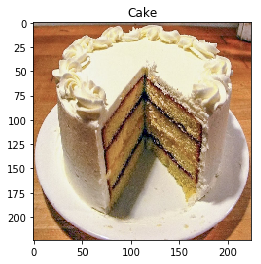

In [4]:
# Check your function 
img = load_and_prep_image("./Pound_layer_cake.jpg",
                   image_shape = 224,
                   scale = True)

plt.imshow(img)
plt.title("Cake")

In [5]:
# plot confusion matrix, base on scikit-learn
def plot_confusion_matrix(y_true,y_pred,classes= None,figsize = (10,10),
                         text_size = 15,norm = False,savefig = True):
    '''
    Makes a labelled confusion matrix comparing predictions and ground truth labels
    If classes is passed, confusion matrix will be labelled, if not, integer class values will be used
    
    Arguments:
        y_true (Array) --- Array of truth labels (must ne same shape as y_pred)
        y_pred (Array) --- Array of predicted labels (must be same shape as y_true)
        classes (Array) --- Array of classes labels (e.g string form), If 'None' integer labels are used
        figsize (Tuple) --- Size of output figure text (default = (10,10))
        text_size --- Size of ouput figure text (default = 15)
        norm (Bool) --- Normalize values or not (default = False)
        savefig (Bool) --- Save your confusion matrix figure or not (default = True)
    Return:
        Show a labelled confusion matrix plot comaring y_true and y_pred
    
    Example:
        plot_confusion_matrix(y_true = test_labels, # ground truth test labels
                                y_pred = y_preds, # predicted labels
                                classes = class_name. # array of class label names
                                figsize = (15,15),
                                text_size = 10
                                
                                )
    '''
    # Create confusion matrix
    cm = confusion_matrix(y_true,y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis = 1)[:,np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we are dealing with
    
    # Plot the figure and make it pretty
    fig,ax = plt.subplots(figsize = figsize)
    cax = ax.matshow(cm,cmap = plt.cm.Blues) # colors will represent how correct a class is, darker == better
    fig.colorbar(cax)
    
    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
        
    # Label the axes
    ax.set(title = 'Confusion Matrix',
           xlabel = "Predicted label",
           ylabel = "True label",
           xticks = np.arange(n_classes),
           yticks = np.arange(n_classes),
           xticklabels = labels, # axes will labeled with class name(if they exist) or ints
           yticklabels = labels
          )
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()
    
    # Set the threshold for different color
    threshold = (cm.max() + cm.min())/2
    
    # Plot the text on each cell
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        if norm:
            plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)",
                     horizontalalignment = 'center',
                     color = 'white' if cm[i,j] > threshold else "black",
                     size = text_size
                    )
    # Save the figure to current working directory
    if savefig:
        fig.savefig('confusion_matrix.png')    

In [34]:
# Make function to predict on images and plot them (works with multi-class)
def pred_and_plot(model,filename,class_names):
    '''
    Imports an image located at filename, makes a prediction on it with
    a trained model an plots the image with the predicted class as the title.
    
    Arguments:
        model(machine learning model) --- your model
        filename(string) --- your image's name
        class_names(list) --- your predict labels
    
    Return:
        predicted label and display the image
        
    '''
    # import the target image and preprocess it
    img = load_and_prep_image(filename)
    # make a prediction
    pred = model.predict(tf.expand_dims(img,axis = 0)) # (1,height,width,color channels)
    # get the predicted class
    if len(pred[0]) >1: # check for multi class
        pred_class = class_names[pred.argmax()] # if more than one output take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if binary output, round
    #plot the image and predicted class
    plt.imshow(img)
    plt.title(f'Prediction: {pred_class}')
    plt.axis(False)

In [7]:
# Define a function to create tensorboard callback
def create_tensorboard_callback(dir_name,experiment_name):
    '''
    Create a tensorboard callback instand to store log files,
    Stores log files with filepath:
        "dir_name/experiment_name/current_datetime/"
        
    Arguments:
        dir_name --- target directory to store tensorboard log files
        experiment_name --- name of experiment directory (e.g efficientnet_model_1)
    
    Return:
        tensorboard callback
    '''
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback =  tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

In [9]:
def plot_loss_curves(history):
    '''
    Returns sepatate loss curves for training and validation metrics
    
    Arguments:
        history: TensorFlow model History object
        
    Return:
        Display seperately loss and accuracy of train and validation
    '''
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(loss))
    #Plot loss curve
    plt.plot(epochs,loss,label = 'training_loss')
    plt.plot(epochs,val_loss,label = 'validation_loss')
    plt.title('Loss')
    plt.legend()
    # Plot accuracy curve
    plt.figure()
    plt.plot(epochs,accuracy,label = 'training_accuracy')
    plt.plot(epochs,val_accuracy,label = 'validation_accuracy')
    plt.title('Accuracy')
    plt.legend()

In [ ]:
def compare_histories(original_history,new_history,initial_epochs 5):
    '''
    Compares two TensorFlow model history objects
    
    Arguments:
        original_history --- History object of original model (before new history)
        new_history --- History object from continued model training (after original_history)
        initial_epochs --- Number of epochs in original_history (new history plot starts from here)
    '''
    # Get original history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']
    
    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
    
    # Combine original with new history
    total_acc = new_history.history['accuracy']
    total_loss = new_history.history['loss']
    
    total_val_acc = new_history.history['val_accuracy']
    total_val_loss = new_history.history['val_loss']
    
    # Make plot
    
    